In [175]:
import os, sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.io as io
from numpy.linalg import inv
import cmath

%matplotlib inline

base_folder = './data/'

image_num = 1
data = io.loadmat('./data/ex1.mat')
X_3D = data['X_3D'][0]
Y_3D = data['X_3D'][1]
Z_3D = data['X_3D'][2]
TVecs = data['TVecs']		# Translation vector: as the world origin is seen from the camera coordinates
RMats = data['RMats']		# Rotation matrices: converts coordinates from world to camera
kc = data['dist_params']	# Distortion parameters
Kintr = data['intinsic_matrix']	# K matrix of the cameras

imgs = [cv.imread(base_folder+str(i).zfill(5)+'.jpg') for i in range(TVecs.shape[0])]

('full RT shape: ', (4, 4))
('full K shape: ', (3, 3))
('P shape: ', (3, 4))
('xyz shape: ', (4,))
('2D points shape: ', (40, 3))
('undistorted_pnts shape: ', (40, 3))


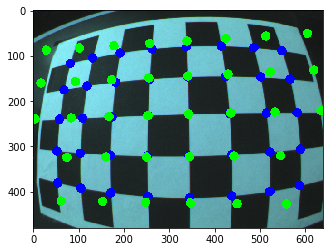

In [184]:
def get_transrot_matrix(R,T):
    RT = np.hstack((R, T))
    lower_part = np.array([0,0,0,1])
    full_RT = np.vstack((RT,lower_part))
    return full_RT

def get_calibration_matrix(K):
    right_part = np.array([[0],[0],[0]])
    K_I3O3 = np.hstack((K, right_part))
    return K_I3O3

def get_distortion_coeff(xyz, k):
    r2 = xyz[0]**2+xyz[1]**2
    r4 = r2**2
    r6 = r2**4
    return 1 + k[0]*r2 + k[1]*r4 + k[4]*r6

def undist_pnt(x, distortion_parameters):
    coeff = get_distortion_coeff(x, distortion_parameters)
    return np.array([x[0]*coeff, x[1]*coeff])

def undistort(X, K, distortion_parameters):
    undistorted_pnts = []
    for idx,x in enumerate(X):
        normalized_pnt = pix_to_normalize_coords(x,K)
        undist_norm = undist_pnt(normalized_pnt, distortion_parameters)
        undist_pix = normalize_to_pix_coords(np.vstack((undist_norm,1)),K)
        undistorted_pnts.append(undist_pix.ravel())
    return np.array(undistorted_pnts)

def pix_to_normalize_coords(X,K):
    K_1 = inv(K)
    return np.dot(K_1, X)

def normalize_to_pix_coords(X,K):
    return np.dot(K,X) 

def project_points(X, K, R, T, distortion_flag=False, distortion_params=None):
    """
    Your implementation goes here!
    """
    X_camera = []
    RT = get_transrot_matrix(R, T)
    print("full RT shape: ", RT.shape)
    K_I3O3 = get_calibration_matrix(K)
    print("full K shape: ", K.shape)
    P = np.dot(K_I3O3,RT)
    print("P shape: ", P.shape)
    for idx in range(X.shape[1]):
        x = X[0][idx]
        y = X[1][idx]
        z = X[2][idx]
        xyz = np.array([x,y,z,1])
        if idx == 0: # just for debugging
            print("xyz shape: ", xyz.shape)
        uvw = np.dot(P,xyz)
        # get x, y in pixel coords by u/w and v/w
        X_camera.append(uvw[:3]/uvw[-1])
    X_camera = np.array(X_camera)
    # Project points from 3d world coordinates to 2d image coordinates
    return X_camera

def project_and_draw(img, X_3d, K, R, T, distortion_flag, distortion_parameters):
    """
        Your implementation goes here!
    """
    # call your "project_points" function to project 3D points to camera coordinates
    # draw the projected points on the image and save your output image here
    pnts = project_points(X_3d, K, R, T)
    print("2D points shape: ", pnts.shape)
    if distortion_flag is True:
        undistorted_pnts = undistort(pnts, K , distortion_parameters)
        print("undistorted_pnts shape: ", undistorted_pnts.shape)
        for idx,pnt in enumerate(undistorted_pnts):
            drawed = cv.circle(img, (int(pnt[0]), int(pnt[1])), 5, (0,0,255),10)
    for idx,pnt in enumerate(pnts):
        drawed = cv.circle(img, (int(pnt[0]), int(pnt[1])), 5, (0,255,0),10)
    plt.imshow(drawed)
    plt.show()
    
image_num=23
project_and_draw(imgs[image_num], X_3D, Kintr, RMats[image_num], 
                 TVecs[image_num], True, kc)